In [1]:
import os

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize
import math
from scipy import integrate
import time

from cdcm import *
from cdcm_utils.derivatives import *
from cdcm_utils.calibration import calibrate_parameters
from figures import *

### System Defnition ####

In [2]:
class DampedHarmonicOscillator(System):

    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

    def define_internal_nodes(self, dt, zeta_val, **kwargs):
                       
        zeta = Parameter(
            value=zeta_val,
            name='zeta',
            units=None,
        )
        omega_o = Parameter(
            value=2.16,
            name='omega_o',
            units="rad/s",
        )
        
        x1 = State(
            name="x1",
            value=0.,
            units="m",
        )
        
        x2 = State(
            name="x2",
            value=1.,
            units="m/s",
        )
        
        @make_function(x1)
        def calc_x1(x1=x1, x2=x2, dt=dt):
            return x1 + x2*dt
        
        @make_function(x2)
        def calc_x2(
            x1=x1,
            x2=x2,
            wo=omega_o,
            z=zeta,
            dt=dt
        ):
            return x2 + dt*(-2*z*wo*x2-wo**2*x1)

#### Helper Functions ####

In [3]:
def make_sys(dt,name,zeta_val):
    with System(name=name) as sys:
        clock = make_clock(dt=dt, units='seconds')
        dho = DampedHarmonicOscillator(
                name='dho', 
                dt=clock.dt,
                zeta_val=zeta_val
        )
    return sys

In [4]:
def fetch_save_data(path,test_saver,sp=''):
    res = test_saver.file_handler[path][:]
    if sp:
        np.savetxt(sp, res, delimiter=",")
        print('saved')
    return res

In [5]:
def plot_prediction(data_dict, sys, test_saver, t_data):
    x1_data = data_dict[sys.dho.x1]
    x2_data = data_dict[sys.dho.x2]
    x1_pred = fetch_save_data(
        path=f"{sys.name}/dho/x1",
        test_saver=test_saver,
    )
    x2_pred = fetch_save_data(
        path=f"{sys.name}/dho/x2",
        test_saver=test_saver,
    )
    fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
    ax.plot(t_data,x1_data,'c',label='x1_data')
    ax.plot(t_data, x2_data,'y',label='x2_data')
    ax.plot(t_data, x1_pred,'r--',label='x1 pred')
    ax.plot(t_data, x2_pred,'k-.',label='x2 pred')
    plt.legend()
    plt.show()

In [6]:
def get_simuln_result(sys, max_steps, data_dict):
    
    
    def set_ic():
        if data_dict:
            sns = list(data_dict.keys())
            for sn in sns:
                sn.value = data_dict[sn][0]
        
    file_name = "damped_simple_harmonic_egs.h5"

    if os.path.exists(file_name):
        os.remove(file_name)

    saving_frac = 1 # saving done every saving_frac*dt instant
    test_saver = SimulationSaver(
        file_name,
        sys,
        max_steps=math.ceil(max_steps/saving_frac)
    )
    simulator = Simulator(sys)

    now = time.time()
    simulator.add_event(0., set_ic)
    for i in range(max_steps):
        simulator.forward()
        if i%saving_frac==0:
            test_saver.save()
        simulator.transition()
    print('time taken (s)',time.time()-now)
    return test_saver

#### Data generation using CDCM model ####

In [7]:
max_steps = 250*2
zeta_val = 0.032
dt = 0.01
org_sys = make_sys(dt=dt,name='org_sys', zeta_val=zeta_val)
ts_org_sys = get_simuln_result(sys=org_sys, max_steps=max_steps, data_dict={})
t_data = np.arange(0.,max_steps*dt,dt)

time taken (s) 0.39020705223083496


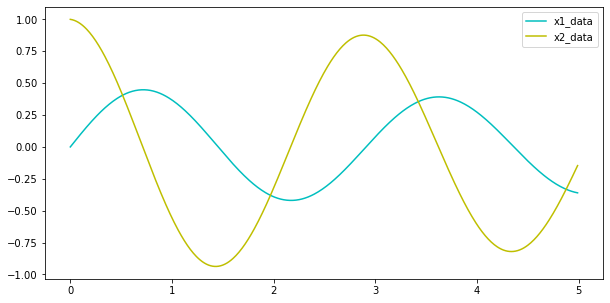

In [8]:
fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
x1s = fetch_save_data(
            "org_sys/dho/x1",
            ts_org_sys,
        )
x2s = fetch_save_data(
            "org_sys/dho/x2",
            ts_org_sys,
        )
ax.plot(t_data,x1s,'c',label='x1_data')
ax.plot(t_data, x2s,'y',label='x2_data')
plt.legend()
plt.show()

### Calibration without modeling error ###

In [9]:
sys_to_cal = make_sys(dt=dt,name='sys_to_cal', zeta_val=0.1)

In [10]:
data_dict = {
    sys_to_cal.dho.x1:
        fetch_save_data(
            "org_sys/dho/x1",
            ts_org_sys,
        ),
    sys_to_cal.dho.x2:
        fetch_save_data(
                "org_sys/dho/x2",
                ts_org_sys,
            ),
}

In [11]:
loss_vals = calibrate_parameters(
        simulator=Simulator(sys_to_cal),
        dt=dt,
        max_steps=max_steps,
        data_dict=data_dict,
        parameters=[sys_to_cal.dho.zeta],
        optimizer='BFGS',
        gd_tol=1e-5,
        gd_max_iter=200,
        tval=0.,
        lr = 0.75,
)

calibration starts at t = 0.0
loss 0.02504774
loss 0.022168772
loss 0.017121436
loss 0.00018002141
loss 0.00011285641
loss 6.0922237e-05
loss 6.6968765e-05
loss 6.5344575e-05
loss 6.508924e-05
loss 6.3708074e-05
loss 5.811004e-05
loss 6.3792555e-05
loss 6.22278e-05
loss 6.030004e-05
loss 6.588512e-05
loss 5.7900415e-05
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 5
         Function evaluations: 16
         Gradient evaluations: 16
parameters: [0.03200292]


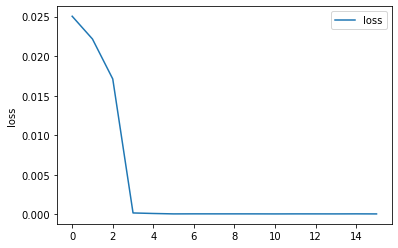

In [13]:
loss_vals = np.array(loss_vals)
plt.plot(loss_vals[loss_vals<20.],label="loss")
plt.ylabel('loss')
plt.legend()

In [14]:
print('rel error (%) in calibrated zeta',100*(1-sys_to_cal.dho.zeta.value/org_sys.dho.zeta.value))

rel error (%) in calibrated zeta -0.009135710132524011


time taken (s) 4.156141996383667


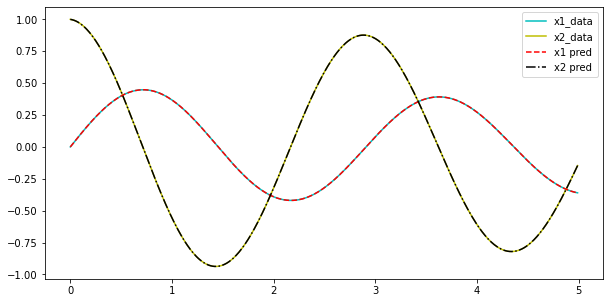

In [15]:
plot_prediction(
    data_dict,
    sys_to_cal,
    test_saver=get_simuln_result(sys_to_cal, max_steps, data_dict),
    t_data=t_data,
)

### Calibration with modeling error ###
Data is generated by solving the ode using scipy odeint package.

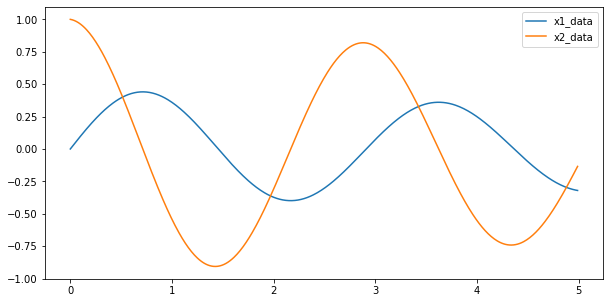

In [16]:
def ode_soln(x,t):
    return [x[1], -omega_o**2*x[0]-2*zeta*omega_o*x[1]]
omega_o = 2.16
zeta = 0.032
dt = 0.01
max_steps = 250*2
ts = np.arange(0.,max_steps*dt,dt)
soln = integrate.odeint(ode_soln, [0,1], ts)

x1_data = soln[:,0]
x2_data = soln[:,1]
t_data = np.arange(0.,max_steps*dt,dt) 

fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
ax.plot(t_data,x1_data,label="x1_data")
ax.plot(t_data,x2_data,label="x2_data")
plt.legend()
plt.show()

In [17]:
sys_to_cal = make_sys(dt=dt,name='sys_to_cal', zeta_val=0.1)

In [18]:
data_dict = {
    sys_to_cal.dho.x1:x1_data,
    sys_to_cal.dho.x2:x2_data,
}

In [19]:
loss_vals = calibrate_parameters(
        simulator=Simulator(sys_to_cal),
        dt=dt,
        max_steps=max_steps,
        data_dict=data_dict,
        parameters=[sys_to_cal.dho.zeta],
        optimizer='BFGS',
        gd_tol=1e-5,
        gd_max_iter=200,
        tval=0.,
        lr = 0.75,
)

calibration starts at t = 0.0
loss 0.015456219
loss 0.0148764085
loss 0.010042621
loss 0.007867807
loss 0.0016979729
loss 0.0005592948
loss 0.00017871906
loss 0.0001290799
Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
parameters: [0.0427827]


In [20]:
print('rel error (%) in calibrated zeta',100*(1-sys_to_cal.dho.zeta.value/org_sys.dho.zeta.value))

rel error (%) in calibrated zeta -33.695929752326606


time taken (s) 4.183315992355347


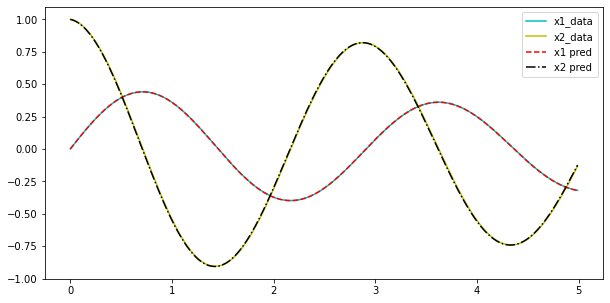

In [21]:
plot_prediction(
    data_dict,
    sys_to_cal,
    test_saver=get_simuln_result(sys_to_cal, max_steps, data_dict),
    t_data=t_data,
)